In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


plt.style.use("dark_background")

In [4]:
% cd /content/drive/MyDrive/Colab Notebooks/Solar_Flares

/content/drive/MyDrive/Colab Notebooks/Solar_Flares


In [5]:
df = pd.read_csv("data/StandFord_2020.csv")

print(df.dtypes)

Dates      object
Signal    float64
dtype: object


In [6]:
df['Dates'] = pd.to_datetime(df["Dates"])

df.set_index("Dates", inplace = True)
df

,Signal
Dates,
2020-05-11 00:00:00,8451.370046
2020-05-11 00:00:05,8449.143841
2020-05-11 00:00:10,8446.917636
2020-05-11 00:00:15,8444.691431
2020-05-11 00:00:20,8442.465226
...,...
2020-05-11 20:22:15,5709.362250
2020-05-11 20:22:20,5719.664779
2020-05-11 20:22:25,5729.967309


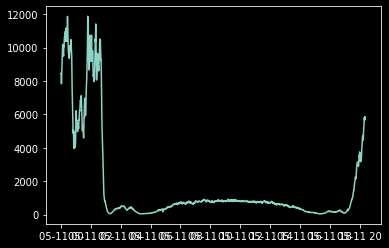

In [7]:
plt.plot(df)

In [8]:
!pip install pmdarima

pvalue =  0.07858315612546105  if above 0.05, data is not stationary


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead


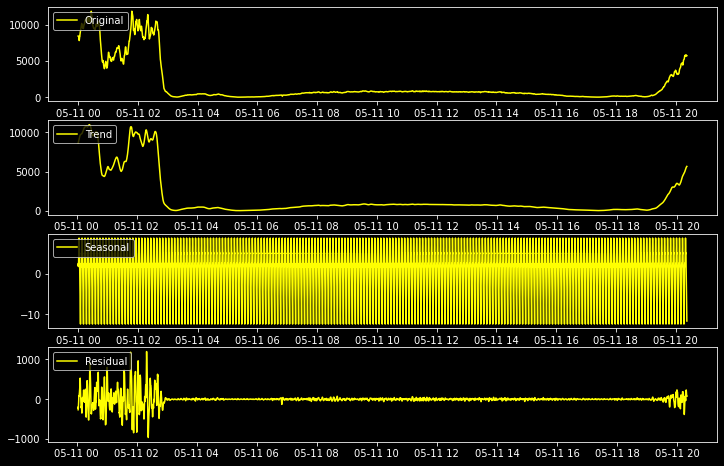

In [9]:
#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(df)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is not stationary, we may need SARIMA and not just ARIMA


#Extract and plot trend, seasonal and residuals. 
from statsmodels.tsa.seasonal import seasonal_decompose 

decompfreq = 6*12


decomposed = seasonal_decompose(df['Signal'],  
                            model ='additive',
                            freq=decompfreq)

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid


plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df, label='Original', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()


In [ ]:

from pmdarima.arima import auto_arima

# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components
arima_model = auto_arima(df['Signal'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=5)   

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=102546.435, Time=3.31 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=130534.175, Time=0.71 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=98669.563, Time=7.91 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=111927.273, Time=21.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=103938.220, Time=1.77 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=95785.889, Time=19.99 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=95293.430, Time=31.43 sec


In [ ]:
# To print the summary 
print(arima_model.summary() ) #Note down the Model and details.
# Model: SARIMAX(0, 1, 1)x(2, 1, [], 12)

In [ ]:

#Split data into train and test
size = int(len(df) * 0.66)
X_train, X_test = df[0:size], df[size:len(df)]


In [ ]:

# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(X_train['Signal'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 1, 12)) 
  
result = model.fit() 
result.summary() 


#Train prediction
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index) 

#Prediction
start_index = len(X_train)
end_index = len(df)-1
prediction = result.predict(start_index, end_index).rename('Predicted') 
#Rename the column

# plot predictions and actual values 
prediction.plot(legend = True) 
X_test['Signal'].plot(legend = True) 


import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test, prediction))
print('Test Score: %.2f RMSE' % (testScore))

#from sklearn.metrics import r2_score
#score = r2_score(X_test, prediction)
#print("R2 score is: ", score)

#Forecast.. You can re-train on the entire dataset before forecasting
#For now let us use the trained model
# Forecast for the next 3 years 
forecast = result.predict(start = len(df),  
                          end = (len(df)-1) + 3 * 12,  
                          typ = 'levels').rename('Forecast') 
  
plt.figure(figsize=(12,8))
plt.plot(X_train, label='Training', color='green')
plt.plot(X_test, label='Test', color='yellow')
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='Left corner')
plt.show()